# Training a Convolutional Neural Network for Classification

## Install Dependencies in Jupyter Notebook

In [42]:
# Install necessary libraries directly in the notebook 
%pip install tensorflow numpy matplotlib seaborn pandas tabulate scipy scikit-learn

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\projects\ebook_object_detection\chapters\cnn_classification\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Required Libraries

In [43]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tabulate import tabulate
import random
import matplotlib.image as mpimg
from tensorflow.keras import layers, models


## Load Dataset

In [44]:
# Define directory paths
train_dir = 'archive/train'
test_dir = 'archive/test'

# Load CSV files for train and test labels
train_labels_df = pd.read_csv(os.path.join(train_dir, 'train_label.csv'))
test_labels_df = pd.read_csv(os.path.join(test_dir, 'test_label.csv'))

### Convert Labels to String format (Required by ImageGenerator)

In [45]:
# Convert the labels in the dataframe to strings
train_labels_df['label'] = train_labels_df['label'].astype(str)
test_labels_df['label'] = test_labels_df['label'].astype(str)

## Data Exploration

### Statistics

In [46]:
total_data = [
    ["Train", train_labels_df.shape[0]],
    ["Test", test_labels_df.shape[0]]
]
print(tabulate(total_data, headers=["Type", "Count"], tablefmt="grid"))


+--------+---------+
| Type   |   Count |
+========+=========+
| Train  |   18388 |
+--------+---------+
| Test   |    3998 |
+--------+---------+


In [47]:
# Count the number of cats and dogs in the train dataset
train_cat_count = train_labels_df[train_labels_df['label'] == "0"].shape[0]
train_dog_count = train_labels_df[train_labels_df['label'] == "1"].shape[0]

# Count the number of cats and dogs in the test dataset
test_cat_count = test_labels_df[test_labels_df['label'] == "0"].shape[0]
test_dog_count = test_labels_df[test_labels_df['label'] == "1"].shape[0]

# Prepare the data for display using tabulate
train_data = [
    ['Cats', train_cat_count],
    ['Dogs', train_dog_count]
]

test_data = [
    ['Cats', test_cat_count],
    ['Dogs', test_dog_count]
]

# Display the results using tabulate
print("Train Data:")
print(tabulate(train_data, headers=["Label", "Count"], tablefmt="grid"))

print("\nTest Data:")
print(tabulate(test_data, headers=["Label", "Count"], tablefmt="grid"))


Train Data:
+---------+---------+
| Label   |   Count |
+=========+=========+
| Cats    |    7917 |
+---------+---------+
| Dogs    |   10471 |
+---------+---------+

Test Data:
+---------+---------+
| Label   |   Count |
+=========+=========+
| Cats    |    1999 |
+---------+---------+
| Dogs    |    1999 |
+---------+---------+


### Visualize Data Sample

OSError: [Errno 28] No space left on device

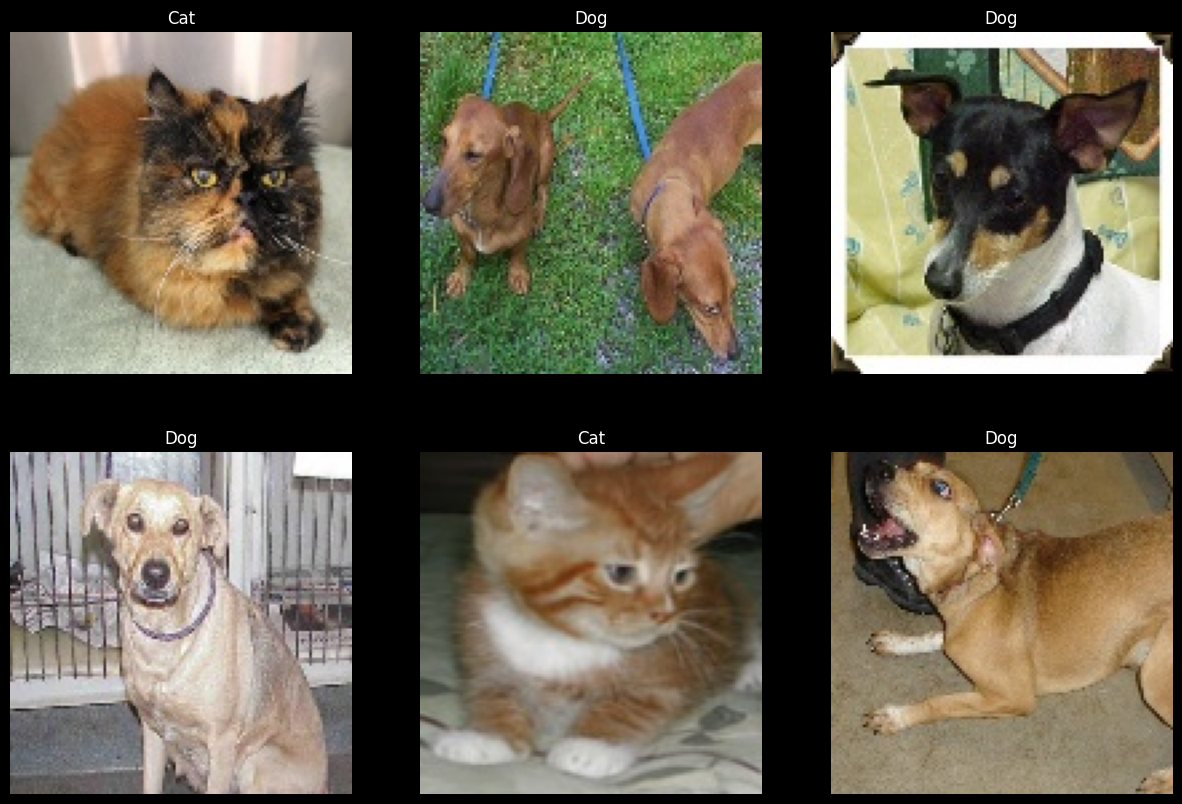

In [48]:
# Define a function to display and save random images from the train dataset
def visualize_random_images(train_dir, num_images=6, image_size=(128, 128), save_path="random_images.png"):
    # Set dark mode
    plt.style.use("dark_background")
    
    # Get all image filenames from the train directory
    train_image_files = train_labels_df['file name'].tolist()
    
    # Randomly sample a specified number of images
    random_images = random.sample(train_image_files, num_images)
    
    # Set up the plot (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Loop through the random images and display them
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(train_dir, img_file)
        img = mpimg.imread(img_path)
        
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Display the corresponding label (0 for cat, 1 for dog)
        label = train_labels_df[train_labels_df['file name'] == img_file]['label'].values[0]
        label_name = 'Cat' if label == "0" else 'Dog'
        axes[i].set_title(label_name, color="white")  # Set title color for dark mode
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="black")
    plt.show()

# Visualize and save 6 random images from the train set
visualize_random_images(train_dir, num_images=6, save_path="random_images_dark.png")


## Data Preprocessing (ImageGenerator)

In [ ]:
# Create an ImageDataGenerator for data augmentation on the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    shear_range=0.2,  # Random shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Create a validation data generator (no augmentation for validation data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from the directories using the labels and paths from CSV
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    directory=train_dir,
    x_col='file name',
    y_col='label',
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='binary'  # Binary classification (cat vs dog)
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_dir,
    x_col='file name',
    y_col='label',
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='binary'  # Binary classification (cat vs dog)
)


## Building the CNN Model

In [ ]:
# Initialize the model
model = models.Sequential()

# Add Convolutional Layers and Pooling Layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the results to feed into a fully connected layer
model.add(layers.Flatten())

# Add Dense Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summarize the model architecture
model.summary()

## Training the Model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

## Model Perfomance

In [ ]:
# Assuming you have saved the history of the training process in the variable 'history'
history = model.history.history

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.savefig("train_perfomance.png", dpi=300, bbox_inches="tight", facecolor="black")
plt.show()

## Save the Model

In [ ]:
# Save the trained model
model.save('model.h5')  # This will save the model as 'model.h5' in the current directory

## Evaluate the model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

# Prepare the results in a table format
results = [
    ["Test Loss", test_loss],
    ["Test Accuracy", test_accuracy]
]

# Print the table
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

## Visualize Some Predictions

In [ ]:
# Get a batch of images and their true labels from the validation generator
images, true_labels = next(validation_generator)

# Make predictions on the batch of images
predictions = model.predict(images)

# Convert the predicted labels to binary (0 or 1) for classification
predicted_labels = (predictions > 0.5).astype('int32')

# Randomly select a few images to display
num_images_to_display = 6
indices = random.sample(range(images.shape[0]), num_images_to_display)

# Create a figure to display the images in a 2x3 grid
plt.figure(figsize=(12, 8))

for i, index in enumerate(indices):
    plt.subplot(2, 3, i + 1)  # Create 2 rows and 3 columns
    img = images[index]
    true_label = true_labels[index]
    predicted_label = predicted_labels[index]
    
    # Show image
    plt.imshow(img)
    plt.axis('off')
    
    # Show true and predicted labels
    plt.title(f"True: {'Cat' if true_label == 0 else 'Dog'}, Pred: {'Cat' if predicted_label == 0 else 'Dog'}")

# Save the figure
plt.savefig("cat_dog_results", dpi=300, bbox_inches="tight", facecolor="black")
plt.show()

In [ ]:
true_labels

In [ ]:
# Initialize empty lists to store true and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the validation generator (test set)
for images, true_labels_batch in validation_generator:
    # Make predictions on the batch of images
    predictions = model.predict(images)
    
    # Convert the predicted labels to binary (0 or 1) for classification
    predicted_labels_batch = (predictions > 0.5).astype('int32')
    
    # Append the true and predicted labels to the lists
    all_true_labels.extend(true_labels_batch)
    all_predicted_labels.extend(predicted_labels_batch)

    # Break after one full pass through the dataset
    if len(all_true_labels) >= validation_generator.samples:
        break

# Compute the confusion matrix on all true and predicted labels
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# Save the figure
plt.savefig("confusion matrix", dpi=300, bbox_inches="tight", facecolor="black")
plt.show()